In [57]:
import pandas as pd
raw_data=pd.read_csv("comptage-velo-donnees-compteurs.csv",sep=";")

data=raw_data.loc[:,["id","sum_counts","date","coordinates"]]
data=data.rename(columns={"sum_counts":"counts"})

data=data.drop(data[data.coordinates.isnull()].index,axis=0)
#FURHTER EXPLORE: there are counters with isnull().sum()!=0 Always the same? Interpolate or equal 0?

data=data.astype({"id":int})

#Only care relative time (people always go to work at 8am, dont care about UTC)
split_date=data["date"].str.split("+",expand=True)
data["date"]=split_date[0]
data["UTC+"]=split_date[1]
data["date"]=pd.to_datetime(data['date'])#,utc=True)
# format='%Y-%m-%dT%H:%M:%S%z'

data["day"]=data['date'].dt.date
data["hour"]=data["date"].dt.hour #Since data.date.dt.minute.sum()=0, dont care about else

data[["lat","lon"]]=data["coordinates"].str.split(",",expand=True).astype(float)
data["coordinates"]=data["coordinates"].str.split(",",expand=False)
data["coordinates"].apply(lambda x: [float(x[0]),float(x[1])])

data["weekend"]=data["date"].dt.weekday>4

<Axes: xlabel='date'>

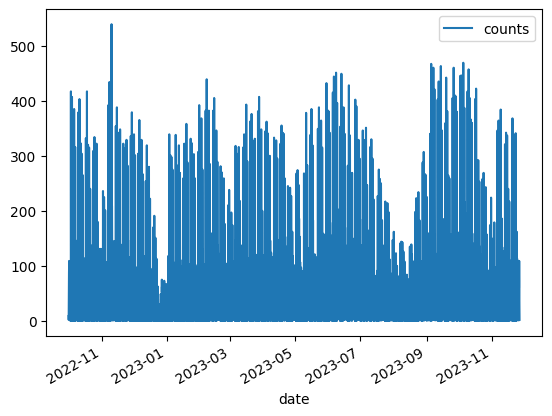

In [58]:
station_test=data[data["id"]==data["id"][0]]
station_test.plot(x="date",y="counts")

<Axes: xlabel='date'>

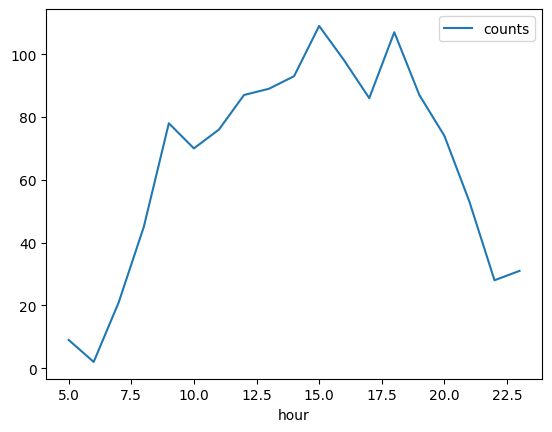

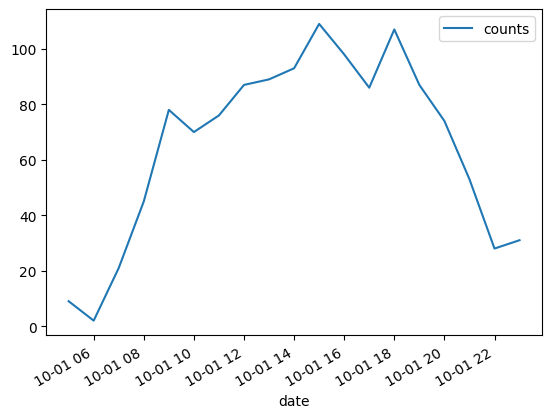

In [59]:
day_station_test=station_test[station_test["day"]==station_test["day"][0]]
day_station_test.sort_values("hour").plot(x="hour",y="counts",)
day_station_test.plot(x="date",y="counts")

<Axes: xlabel='hour'>

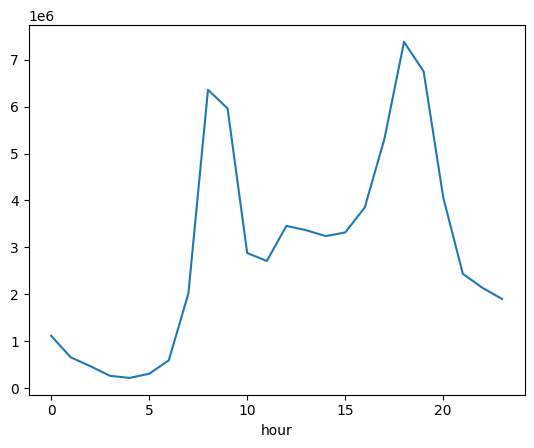

In [60]:
traffic_pattern=data.groupby("hour")["counts"].sum()
traffic_pattern.plot()

Text(0.5, 1.0, 'Traffic flow simulation')

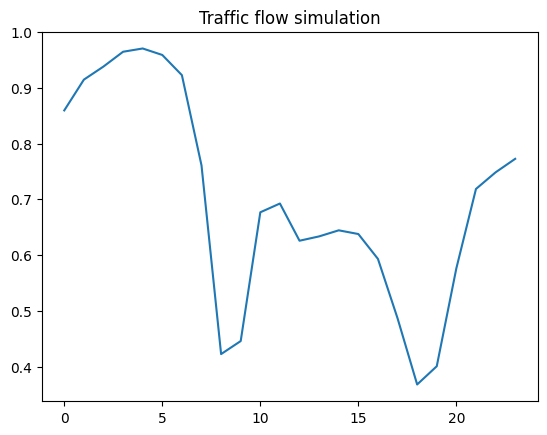

In [61]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.exp(-traffic_pattern/traffic_pattern.max()))
plt.title("Traffic flow simulation")

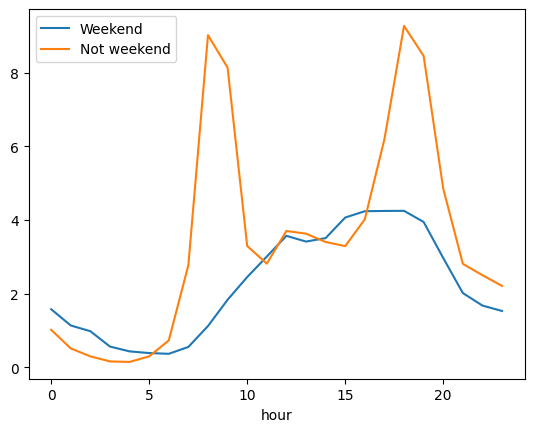

In [62]:
weekend=data[data["weekend"]==True]
(weekend.groupby("hour")["counts"].sum()/len(weekend)).plot(label=("Weekend"))

nonweekend=data[data["weekend"]==False]
(nonweekend.groupby("hour")["counts"].sum()/len(nonweekend)).plot(label=("Not weekend"))

plt.legend();


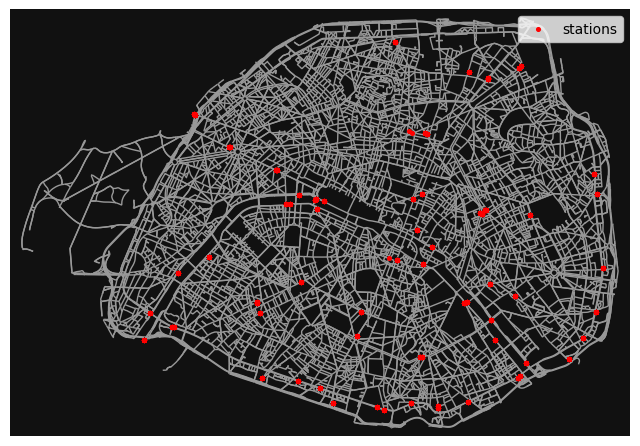

In [63]:
import osmnx as ox
map = ox.graph_from_place('Paris, France', network_type='drive',simplify=True)

fig,ax=ox.plot_graph(map,show=False, close=False,node_size=0)
data.plot.scatter(x="lon",y="lat",ax=ax,c="red",s=7,label="stations")

plt.legend();

Route generator:

In [46]:
import osmnx as ox
G = ox.graph_from_place('Paris, France', network_type='drive',simplify=True)

In [57]:
def edges_to_nodes(track):
    return [edge[0] for edge in track]

def nodes_to_edges(track):
    return [(track[i],track[i+1]) for i in range(len(track)-1)]

In [103]:

from datetime import datetime
def generate_time_v0(G,track,start_t,sampling_rate=1,v0=20):
    """
    Adds timestemps to a list of nodes every samping_rate seconds
    simulating a movement at constant speed v0 [km/h]
    """   
    extended_track=[]
    edge_list=nodes_to_edges(track)
    edge_index=0
    t=start_t
    t_enter_edge=t
    edge=edge_list[0]
    while edge!=edge_list[-1]:
        edge_info=G[edge[0]][edge[1]][0]

        l_traversed=(t-t_enter_edge)*(v0/3.6)
        l=edge_info["length"]
        if l_traversed>l:
            edge_index+=1
            edge=edge_list[edge_index]
            
            l_traversed-=l
            t_enter_edge=t
            #TODO: Asumes that the l excess fits in the next edge, but maybe no.
            #But next iter it checks if l_t>l and changes edge, but should not add time...
        osmid=edge_info['osmid']
        x=[t,edge[0],edge[1],osmid]
        extended_track.append(x)

        t+=sampling_rate

    return extended_track

In [107]:
import networkx as nx
from numpy.random import choice
def route_generator_v0(G,n=10,max_iter_factor=10,
                       start_t=None, data_every_t=24*3600, sampling_rate=1,
                       debug=False):
    """
    Generates a lsit of routes by selecting random points in the graph "G".

    Returns a list of n trajectories T.
    Each trajectory T[i] is a list of list elements in the format:
    [[timestamp, edge_start_node, edge_end_node, edge_osmid], ...]

    If there is not a path between selected nodes (not connected graph) it retries new nodes.
    A budget of n*max_iter_factor retries is set to avoid infinite loop.
    """

    if not start_t:
        start_t=datetime.today().timestamp()

    T=[]
    max_counts=n*max_iter_factor
    counts=0
    t=start_t
    while len(T)<n:
        try:
            orig=choice(list(G.nodes()))
            dest=choice(list(G.nodes()))
            track=nx.shortest_path(G, orig, dest, weight='length')
            extended_track=generate_time_v0(G,track,t,sampling_rate=sampling_rate)
            T.append(extended_track)
            t+=data_every_t
        except nx.exception.NetworkXNoPath:
            if debug:
                print(f"Repeating {len(T)}th trajectory...")
            else:
                pass

        counts+=1
        if counts==max_counts:
            print(f"WARNING: Not all tracks could be generated in {max_counts} iteratons.")
            break

    if debug:
        print("Generation done.") 
    return T

T=route_generator_v0(G,n=1,debug=True)

Generation done.


In [ ]:
import networkx as nx
from numpy.random import choice
def route_generator_v1(G,
                       node_selector,time_generator,
                       n=10,max_iter_factor=10,
                       start_t=None, data_every_t=24*3600, sampling_rate=1,
                       debug=False,
                       **kwargs):
    """
    Generates a list of routes with points selected with the node_selector
    and with time simulated by the time_generator.

    Returns a list of n trajectories T.
    Each trajectory T[i] is a list of list elements in the format:
    [[timestamp, edge_start_node, edge_end_node, edge_osmid], ...]

    If there is not a path between selected nodes (not connected graph) it retries new nodes.
    A budget of n*max_iter_factor retries is set to avoid infinite loop.
    """

    if not start_t:
        start_t=datetime.today().timestamp()

    T=[]
    max_counts=n*max_iter_factor
    counts=0
    t=start_t
    while len(T)<n:
        try:
            orig,dest = node_selector(G,**kwargs)

            track=nx.shortest_path(G, orig, dest, weight='length')
            extended_track=time_generator(G,track,t,sampling_rate=sampling_rate,**kwargs)
            T.append(extended_track)
            t+=data_every_t
        except nx.exception.NetworkXNoPath:
            if debug:
                print(f"Repeating {len(T)}th trajectory...")
            else:
                pass

        counts+=1
        if counts==max_counts:
            print(f"WARNING: Not all tracks could be generated in {max_counts} iteratons.")
            break

    if debug:
        print("Generation done.") 
    return T

T=route_generator_v0(G,n=1,debug=True)

In [ ]:
def node_selector_v0(G,**kwargs):
    """
    Selects two nodes at random from the map G
    """
    orig=choice(list(G.nodes()))
    dest=choice(list(G.nodes()))
    return orig,dest